In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
import jax
import numpy as np
from jax import numpy as jnp
from matplotlib import pyplot as plt

from otf import optim
from otf import time_integration as ti
from otf.system import System_ModelKnown

from plot import plot
from utils import run_update

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray

In [ ]:
def get_initial_values(I, J, J_sim):
    SEED = 42

    # Initial true state
    init = np.random.default_rng(SEED).uniform(size=I + I * J)

    u0 = jnp.array(init[:I])
    v0 = jnp.array(jnp.reshape(init[I:], (I, J)))

    # Initial simulation state
    un0 = jnp.zeros_like(u0)
    vn0 = jnp.zeros((I, J_sim))

    return (
        jnp.concatenate((jnp.expand_dims(u0, axis=1), v0), axis=1),
        jnp.concatenate((jnp.expand_dims(un0, axis=1), vn0), axis=1),
    )

In [ ]:
# Dimensions
I, J = 40, 5
J_sim = J


def true_ode(gs: jndarray, true: jndarray) -> jndarray:
    p1, p2 = gs[6:]
    F, ds = gs[0], gs[1:6]

    u, v = true[:, 0], true[:, 1:]

    up = (
        jnp.roll(u, 1) * (jnp.roll(u, -1) - jnp.roll(u, 2))
        + p1 * jnp.sum(u * v.T, axis=0)
        - p2 * u
        + F
    )

    vp = -ds * v - jnp.expand_dims(p1 * u**2, axis=1)

    return jnp.concatenate((jnp.expand_dims(up, axis=1), vp), axis=1)


def assimilated_ode(
    cs: jndarray, assimilated: jndarray, F: float, ds: jndarray
) -> jndarray:
    p1, p2 = cs

    u, v = assimilated[:, 0], assimilated[:, 1:]

    up = (
        jnp.roll(u, 1) * (jnp.roll(u, -1) - jnp.roll(u, 2))
        + p1 * jnp.sum(u * v.T, axis=0)
        - p2 * u
        + F
    )

    vp = -ds * v - jnp.expand_dims(p1 * u**2, axis=1)

    return jnp.concatenate((jnp.expand_dims(up, axis=1), vp), axis=1)

In [ ]:
# System evolution parameters
import optax


g1, g2 = 1e-2, 0.5
c1, c2 = g1, g2
c1 *= 0.5
c2 *= 0.5
ds = jnp.array([0.2, 0.5, 1, 2, 5])
F = 8
mu = 50

gs = jnp.array([F, *ds, g1, g2])
cs = jnp.array([c1, c2])

observed_slice = jnp.s_[:, 0]
system = System_ModelKnown(
    mu,
    gs,
    cs,
    observed_slice,
    lambda cs, assimilated: assimilated_ode(cs, assimilated, F, ds),
    true_ode,
)
solver = ti.RK4(system)
optimizer = optax.adam(1e-1)
optimizer = optim.OptaxWrapper(system, optimizer)

# Seems to work though not sure why.
# optimizer = optim.WeightedLevenbergMarquardt(system)

# Doesn't seem to work for the hyperparameters I've tried.
# optimizer = optim.LevenbergMarquardt(system)

# Simulation parameters
dt = 0.04
T0, Tf = 0, 1000
t_relax = 1

cs, u_errors, v_errors, tls = run_update(
    system,
    solver,
    dt,
    T0,
    Tf,
    t_relax,
    *get_initial_values(I, J, J_sim),
    optimizer=optimizer,
)

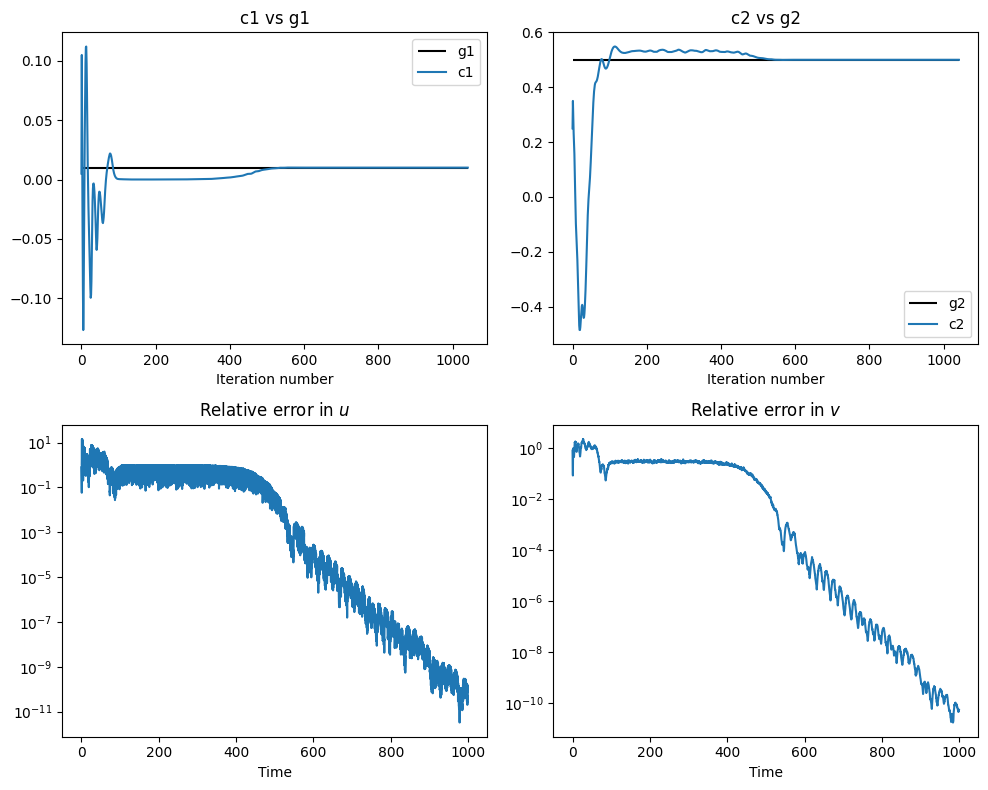

In [ ]:
fig, axs = plot(cs.T[0], cs.T[1], u_errors, v_errors, g1, g2, tls)
plt.show()